The first few attempts have lead to issues - one epoch trains for a very very long time, and never completes.  This is due to not giving a set steps_per_epoch, so this next version will include this and Early Stopping.

In [9]:
import tensorflow as tf
import pickle
from tensorflow.keras.layers import StringLookup
from tensorflow.keras import layers, Model
import pandas as pd
import random
import collections
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [10]:
batch_tunes = 16
# the number of settings per tune
per_tune = 2
batch_size = 32

# Hyperparameters
EMB_DIM    = 32
RNN_UNITS = 32

In [ ]:
# load the dataset
df = pd.read_pickle('data/tokenized_dataset.pkl')
# time to remove tunes with only one setting - at least for training triplet loss
counts = df.tune_id.value_counts()
good_ids = counts[counts >= per_tune].index
df = df[df.tune_id.isin(good_ids)]


In [12]:
# build the vocab
all_notes = sorted({n for seq in df.note_seq for n in seq})
note_lookup = tf.keras.layers.StringLookup(
    vocabulary=all_notes,
    mask_token=None,    # 0 will be reserved for padding
    oov_token="[UNK]"
)
df['note_ids'] = df.note_seq.apply(lambda seq: note_lookup(seq).numpy().tolist())


In [26]:
from sklearn.model_selection import train_test_split

# 1. Get the unique tune IDs
all_tune_ids = df.tune_id.unique()

# 2. Split off test (10%)
trainval_ids, test_ids = train_test_split(
    all_tune_ids, test_size=0.10, random_state=42
)

# 3. Split train vs validation (of the remaining 90%)
train_ids, val_ids = train_test_split(
    trainval_ids, test_size=0.11, random_state=42
)
# 0.11 of 90% ≈ 10% of original, so you end up ~80/10/10
df_train = df[df.tune_id.isin(train_ids)]
df_val   = df[df.tune_id.isin(val_ids)]
df_test  = df[df.tune_id.isin(test_ids)]

val_steps  = len(df_val) // batch_size

steps_per_epoch = len(df_train) // batch_size

In [27]:
def make_balanced_ds(df_split, batch_tunes=16, per_tune=2):
    # build index by tune_id just on df_split
    by_id = defaultdict(list)
    for notes, durs, tid in zip(df_split.note_ids, df_split.dur_seq, df_split.tune_id):
        by_id[int(tid)].append((notes, durs))
    tune_ids = list(by_id.keys())

    def gen():
        while True:
            chosen = random.sample(tune_ids, batch_tunes)
            for tid in chosen:
                examples = random.choices(by_id[tid], k=per_tune)
                for notes, durs in examples:
                    # nested structure: ((notes_list, durs_list), label)
                    yield (notes, durs), tid

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            (
                tf.TensorSpec(shape=(None,), dtype=tf.int32),   # notes_list
                tf.TensorSpec(shape=(None,), dtype=tf.float32)  # durs_list
            ),
            tf.TensorSpec(shape=(), dtype=tf.int32)            # label
        )
    ).padded_batch(
        batch_size = batch_tunes * per_tune,
        # mirror the nested structure: ((notes, durs), label)
        padded_shapes = (
            ([None],    # pad notes_list→[batch, T]
             [None]),   # pad durs_list →[batch, T]
            []         # pad label →[batch]
        ),
        padding_values = (
            (0, 0.0),   # pad notes with 0, durations with 0.0
            0           # pad labels with 0 (unused)
        )
    ).prefetch(tf.data.AUTOTUNE)

    return ds

train_ds = make_balanced_ds(df_train)
val_ds   = make_balanced_ds(df_val)



In [28]:
def pairwise_distances(embeddings):
    # embeddings: [batch, dim]
    # returns a [batch, batch] matrix of squared distances
    dot = tf.matmul(embeddings, embeddings, transpose_b=True)
    sq = tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True)
    # d(i,j) = ||xi - xj||^2 = sq[i] - 2*dot[i,j] + sq[j]
    return tf.maximum(sq - 2.0 * dot + tf.transpose(sq), 0.0)

def batch_hard_triplet_loss(margin=0.3):
    def loss_fn(y_true, y_pred):
        # y_true: [batch] int labels (tune_id)
        # y_pred: [batch, dim] embeddings (already ℓ₂‐normalized or not)
        labels = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        embeddings = y_pred
        # 1) Pairwise distance matrix
        pdist = pairwise_distances(embeddings)
        # 2) Masks for positive / negative pairs
        labels_eq = tf.equal(tf.expand_dims(labels,1), tf.expand_dims(labels,0))  # [B,B]
        mask_pos = tf.cast(labels_eq, tf.float32) - tf.eye(tf.shape(labels)[0])   # zero diagonal
        mask_neg = 1.0 - tf.cast(labels_eq, tf.float32)

        # 3) For each anchor i, hardest positive = max_{j!=i, same label} d(i,j)
        hardest_pos = tf.reduce_max(pdist * mask_pos, axis=1)
        # 4) For each anchor i, easiest negative = min_{k, different label} d(i,k)
        #    to do that, add large constant to positives so they’re ignored in min()
        max_dist = tf.reduce_max(pdist)
        pdist_neg = pdist + max_dist * (1.0 - mask_neg)
        hardest_neg = tf.reduce_min(pdist_neg, axis=1)

        # 5) Combine with margin
        tl = tf.maximum(hardest_pos - hardest_neg + margin, 0.0)
        return tf.reduce_mean(tl)
    return loss_fn


In [29]:
vocab_list = note_lookup.get_vocabulary()
VOCAB_SIZE = len(vocab_list) + 2  
# 1) Define your two inputs
notes_in = layers.Input(shape=(None,), dtype="int32",   name="note_ids")
durs_in  = layers.Input(shape=(None,), dtype="float32", name="durations")

# 2) Embed your notes (this is trainable, starts random)
note_emb = layers.Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMB_DIM,
    mask_zero=True,   # so padding=0 is ignored by downstream RNN
)(notes_in)          # → shape (batch, timesteps, EMB_DIM)

dur_feat = layers.Lambda(
    lambda x: tf.expand_dims(x, -1),
    mask=lambda inputs, mask: mask  # pass the incoming 2D mask straight through
)(durs_in)
# project durations into EMB_DIM via a Dense layer
dur_emb = layers.TimeDistributed(layers.Dense(EMB_DIM))(dur_feat)
# now both note_emb and dur_emb are (B, T, EMB_DIM)
x = layers.Add()([note_emb, dur_emb])

# → shape (batch, timesteps, EMB_DIM + 1)

# 5) Encode with a Bidirectional GRU (return_sequences=True so we can pool)
rnn_out = layers.Bidirectional(
    layers.GRU(RNN_UNITS, return_sequences=True)
)(x)
# → shape (batch, timesteps, 2*RNN_UNITS)

# 6) Pool across time (takes care of variable lengths & masks)
tune_vec = layers.GlobalAveragePooling1D()(rnn_out)
# → shape (batch, 2*RNN_UNITS)

# 7) L2-normalize if you like (makes cosine‐based losses stable)
tune_emb = layers.Lambda(lambda z: tf.math.l2_normalize(z, axis=1))(tune_vec)

# 8) Build & compile
model = Model(inputs=[notes_in, durs_in], outputs=tune_emb)
model.compile(
    optimizer="adam",
    loss=batch_hard_triplet_loss(margin=0.3)
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ durations           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_ids            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None, 1)   │          0 │ durations[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 32)  │      2,112 │ note_ids[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None, 32)  │         64 │ lambda_2[0][0]    │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 32)  │          0 │ embedding_1[0][0… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, None, 64)  │     12,672 │ add_1[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ bidirectional_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 64)        │          0 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,848 (58.00 KB)

 Trainable params: 14,848 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:

callbacks = [
  ModelCheckpoint(
    "saved_models/ckpt_{epoch:02d}.weights.h5",
    save_weights_only=True,
    save_best_only=True,
    monitor="loss",
  ),
  EarlyStopping(
    monitor="loss",
    patience=5,
    restore_best_weights=True,
  ),
  TensorBoard(log_dir="logs/"),
]


In [31]:
history = model.fit(train_ds, epochs=10, steps_per_epoch=steps_per_epoch, validation_data = val_ds, validation_steps = len(df_val), callbacks=callbacks)

Epoch 1/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 149s 157ms/step - loss: 0.2619 - val_loss: 0.1878
Epoch 2/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 148s 157ms/step - loss: 0.1594 - val_loss: 0.1405
Epoch 3/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 152s 161ms/step - loss: 0.1181 - val_loss: 0.1232
Epoch 4/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 147s 155ms/step - loss: 0.0982 - val_loss: 0.1050
Epoch 5/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 145s 153ms/step - loss: 0.0905 - val_loss: 0.1025
Epoch 6/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 142s 150ms/step - loss: 0.0787 - val_loss: 0.0956
Epoch 7/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 145s 154ms/step - loss: 0.0803 - val_loss: 0.0933
Epoch 8/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 146s 155ms/step - loss: 0.0715 - val_loss: 0.0904
Epoch 9/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - loss: 0.0699 - val_loss: 0.0864
Epoch 10/10
944/944 ━━━━━━━━━━━━━━━━━━━━ 146s 155ms/step - loss: 0.0693 - val_loss: 0.0892


In [32]:
# after training…
model.save("saved_models/tune_embedder_v1.keras")  
# → creates a SavedModel directory you can reload anywhere


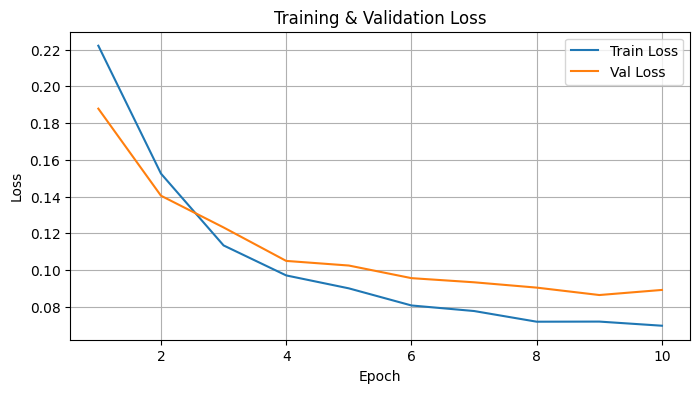

In [33]:
import matplotlib.pyplot as plt

# history is the History object returned by model.fit(...)
train_loss = history.history['loss']
val_loss   = history.history.get('val_loss', None)
epochs     = range(1, len(train_loss) + 1)

plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss,  label='Train Loss')
if val_loss is not None:
    plt.plot(epochs, val_loss,  label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


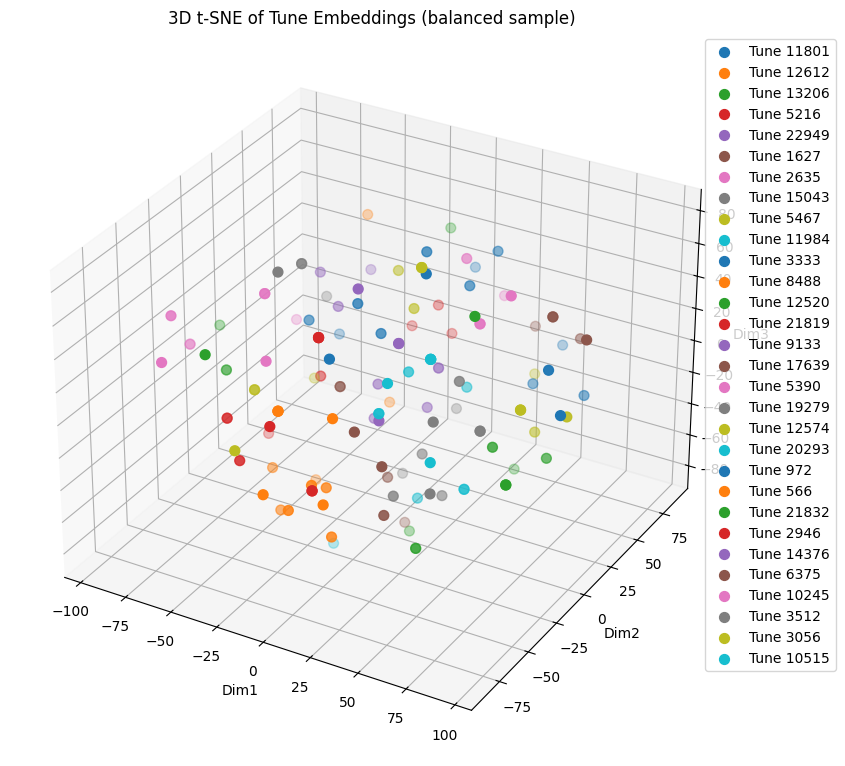

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold     import TSNE
import seaborn as sns
import pandas as pd


# ---- A) Pull one balanced‐batch of examples ----
viz_ds = make_balanced_ds(df_val, batch_tunes=30, per_tune=5)
(v_notes, v_durs), labels_sub = next(iter(viz_ds.take(1)))

# ---- B) Compute embeddings for that batch ----
emb_sub = model.predict([v_notes, v_durs])

# # ---- C) 2D PCA plot ----
# coords2 = PCA(n_components=2).fit_transform(emb_sub)
# plt.figure(figsize=(6,6))
# sc = plt.scatter(coords2[:,0], coords2[:,1],
#                  c=labels_sub, cmap='tab10', s=30)
# plt.title("2D PCA of Tune Embeddings (balanced sample)")
# plt.xlabel("PC1"); plt.ylabel("PC2")
# plt.colorbar(sc, label='tune_id')
# plt.show()

# ---- D) 3D t-SNE plot (optional) ----
# Prepare DataFrame for seaborn
coords3 = TSNE(n_components=3, random_state=42).fit_transform(emb_sub)

df_tsne = pd.DataFrame({
    'Dim1': coords3[:, 0],
    'Dim2': coords3[:, 1],
    'Dim3': coords3[:, 2],
    'tune_id': labels_sub.numpy() if hasattr(labels_sub, 'numpy') else labels_sub
})

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a scatter plot for each unique tune_id
for tune_id in df_tsne['tune_id'].unique():
    mask = df_tsne['tune_id'] == tune_id
    ax.scatter(df_tsne.loc[mask, 'Dim1'], 
              df_tsne.loc[mask, 'Dim2'], 
              df_tsne.loc[mask, 'Dim3'],
              label=f'Tune {tune_id}',
              s=50)

ax.set_title("3D t-SNE of Tune Embeddings (balanced sample)")
ax.set_xlabel("Dim1")
ax.set_ylabel("Dim2")
ax.set_zlabel("Dim3")

# Add legend with tune IDs
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper right')

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()


In [48]:
df_tsne

,Dim1,Dim2,Dim3,tune_id
0,16.596977,-31.293325,10.917399,12845
1,2.030890,-28.328167,-81.110291,12845
2,20.771332,-53.074574,23.263121,12845
3,-4.981132,-47.565800,19.833487,12845
4,8.263701,-54.349743,-1.550002,12845
...,...,...,...,...
145,-21.001217,-53.755524,-67.975403,12124
146,-1.913819,-68.681755,-85.538727,12124
147,-21.001217,-53.755524,-67.975403,12124
148,-1.685391,-67.262039,-56.208977,12124


In [ ]:
# ...existing code...
fig = plt.figure(figsize=(12, 8))  # Made figure larger to accommodate labels
ax = fig.add_subplot(111, projection='3d')
palette = sns.color_palette('tab10', n_colors=len(np.unique(df_tsne['tune_id'])))
colors = df_tsne['tune_id'].map({k: palette[i % len(palette)] for i, k in enumerate(np.unique(df_tsne['tune_id']))})

# Create scatter plot with labels
sc3 = ax.scatter(df_tsne['Dim1'], df_tsne['Dim2'], df_tsne['Dim3'],
                 c=colors, s=50)  # Made points slightly larger

# Add labels for each point
for i, row in df_tsne.iterrows():
    ax.text(row['Dim1'], row['Dim2'], row['Dim3'], 
            f'Tune {row["tune_id"]}',
            size=8)

ax.set_title("3D t-SNE of Tune Embeddings (balanced sample, seaborn colors)")
ax.set_xlabel("Dim1")
ax.set_ylabel("Dim2")
ax.set_zlabel("Dim3")

# Add some padding to the axes to prevent label clipping
ax.margins(0.1)

plt.show()

In [ ]:
# ...existing code...
fig = plt.figure(figsize=(12, 8))  # Made figure larger to accommodate labels
ax = fig.add_subplot(111, projection='3d')
palette = sns.color_palette('tab10', n_colors=len(np.unique(df_tsne['tune_id'])))
colors = df_tsne['tune_id'].map({k: palette[i % len(palette)] for i, k in enumerate(np.unique(df_tsne['tune_id']))})

# Create scatter plot with labels
sc3 = ax.scatter(df_tsne['Dim1'], df_tsne['Dim2'], df_tsne['Dim3'],
                 c=colors, s=50)  # Made points slightly larger

# Add labels for each point
for i, row in df_tsne.iterrows():
    ax.text(row['Dim1'], row['Dim2'], row['Dim3'], 
            f'Tune {row["tune_id"]}',
            size=8)

ax.set_title("3D t-SNE of Tune Embeddings (balanced sample, seaborn colors)")
ax.set_xlabel("Dim1")
ax.set_ylabel("Dim2")
ax.set_zlabel("Dim3")

# Add some padding to the axes to prevent label clipping
ax.margins(0.1)

plt.show()